In [42]:
OPTUNA = True #set to True to run Optuna first, false to use saved hyperparameters
# MODEL_NAME = "xgboost"
MODEL_NAME = "lightgbm"

# check if being run direct (from notebooks folder) or run indirect (called from notebook 10, which already changed working directory to root)
import os
if os.path.basename(os.getcwd()) == "notebooks": 

    INDIRECT = False
    
    os.chdir("..")  ## change working directory to project root when running from notebooks folder to make it easier to import modules and to access sibling folders
    
    from dotenv import load_dotenv # load environment variables from .env file. If being run from notebook 10, this will already have been done
    load_dotenv()

else:
    INDIRECT = True

INDIRECT

True

## Model Testing

Runs Gradient-Boosted Tree (gbt) training models (option to select Xgboost or Lightgbm) and logs the key information to Neptune.ai. 

(Originally 2 notebooks were utilized, one for XGB and one for LGB, but these were converted to this single notebook for convenience. Simple "if" statements are used to select the small differences in code when choosing one or the other.)

If Optuna is set to True, then hyperparameters are tuned first and used for the test run. Otherwise, the current best hyperparameters are kept in a JSON file and are utilized instead. If Optuna is utilized, then a separate Neptune logging run is initialized to record the key tuning data.

Various metrics are calculated and recorded. AUC will likely be of primary interest since the eventual goal is to compare win-lose probabilities against betting odds, not necessarily to accurately predict the winner for each game. Accuracy is an interesting metric though, and is recorded as well.

Along with standard built-in measures for feature importance using weight and gain, Shapley value feature importances are also generated to give a different perspective on feature importances. These Shapley feature importances are local to the specific data run through the model and therefore can be used in some form of adversarial evaluation, such as train data vs test data and/or test split 1 vs test split 2 (see below.)

This model evaluation does include splitting the test set into "early" season data (Test1) and "later" season data (Test2) and comparing the performance on each.

Process flow:

- load data that has gone through feature engineering and selection
- initialize Neptune.ai logging run
- set key options
- fix datatypes for correct date format and decrease memory footprint
- perform any categorical encoding required for XGB or LGB
- drop any features that are not useful and set the target
- load hyperparameters from JSON file or re-tune them with Optuna
- train the model with stratified K-fold cross validation
- output key metrics and feature importances for Out-of-Fold validation set
- run the model on the test/validation set
- output key metrics and feature importances for test/validation data
- split the test/validation data into Test1 (early season) and Test2 (later season)
- run model on each
- output key metrics and feature importances for each
- perform model evaluation, comparing train vs test and test1 vs test2
- if re-tuned hyperparameters are better (per human inspection) then manually run the function to save these as new defaults. (These re-tuned hyperparameters are always logged at Neptune.ai and can be retrieved whenever necessary, but human interaction is required to establish new default parameters because various experiments might not be optimal in the long run.)



In [43]:
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)


from sklearn.model_selection import (
    StratifiedKFold, 
    TimeSeriesSplit,
)

from sklearn.calibration import (   
    calibration_curve,
    CalibratedClassifierCV,
)


import xgboost as xgb
from xgboost import XGBClassifier
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import (
    early_stopping,
    log_evaluation,
)
print('LGB version:', lgb.__version__)

import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances,
)

from src.models.model1.hyperparameters_tuning import (
    XGB_objective,
    LGB_objective,
)

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
from neptune.new.integrations.lightgbm import (
    NeptuneCallback as LGB_NeptuneCallback, 
)

import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

import joblib

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path  #for Windows/Linux compatibility

import json

from datetime import datetime


from src.data.cleaning import (
    process_games,
    add_TARGET,
    split_train_test,
)

from src.data.build_features import (
    fix_datatypes,
    process_features,
    remove_non_rolling,
)

from src.models.model1.train import (
    encode_categoricals,
    plot_calibration_curve,
    calculate_classification_metrics
)

from src.utils.constants import (
    LONG_INTEGER_FIELDS,
    SHORT_INTEGER_FIELDS,
    DATE_FIELDS,
    DROP_COLUMNS,
    CATEGORY_COLUMNS,
)



import warnings
warnings.simplefilter('ignore')

#%config InlineBackend.figure_format = 'svg'


XGB version: 1.6.0
LGB version: 3.3.2


In [44]:
CONFIGS_PATH = Path.cwd() / "configs"
DATA_PATH = Path.cwd() / "data"
NOTEBOOKS_PATH = Path.cwd() / "notebooks"
MODELS_PATH = Path.cwd() / "models"

In [45]:

def update_training_data():
    
    # when this notebook is run from notebook 10_model_training.pipeline, it handles retrieving the most current data from Hopsworks.AI
    # this function here is used to update the training data when one wishes to use local data stored in games.csv instead of connecting to Hopsworks.AI
    # games.csv will need to be first updated itself if the most current data is desired
    # all the pre-processing steps are run again, and the train and test sets are saved to the data folder
    

    games = pd.read_csv(DATA_PATH / "interim" / "games.csv")
    games = process_games(games)
    games = add_TARGET(games)
    games = process_features(games)
    train, test = split_train_test(games)
    train.to_csv(DATA_PATH / "processed" / "train_features.csv",index=False)
    test.to_csv(DATA_PATH / "processed" / "test_features.csv",index=False)
    train.to_csv(DATA_PATH / "processed" / "train_selected.csv",index=False)
    test.to_csv(DATA_PATH / "processed" / "test_selected.csv",index=False)

if INDIRECT == False: #if being run direct, update training data first   
    update_training_data()



In [46]:
TRAIN_NAME = "train_selected.csv"
TEST_NAME = "test_selected.csv"

train = pd.read_csv(DATA_PATH / "processed" / TRAIN_NAME).sample(frac=.3).reset_index(drop=True)
test = pd.read_csv(DATA_PATH / "processed" / TEST_NAME)


**Setup Neptuna.ai experiment tracking**

In [47]:
LOGGING_NOTE = "pipeline test"

try:

    NEPTUNE_API_TOKEN = os.getenv('NEPTUNE_API_TOKEN')
except:
    raise Exception('Set environment variable NEPTUNE_API_TOKEN')
    
PROJECT = "massyl/nba-match-prediction"
PROJECT_OPTUNA = "massyl/nba-match-prediction" #for 2nd run if hyperparameters are tuned
SOURCE = "07_model_testing.ipynb"


run = neptune.init_run(
    project=PROJECT,
    source_files=[SOURCE],
    api_token=NEPTUNE_API_TOKEN,
)
if MODEL_NAME == "xgboost":
    neptune_callback = NeptuneCallback(run=run)
if MODEL_NAME == "lightgbm":
    neptune_callback = LGB_NeptuneCallback(run=run)

run["note"] = LOGGING_NOTE
run["sys/tags"].add([MODEL_NAME,])
run['dataset/train'] = TRAIN_NAME
run['dataset/test'] = TEST_NAME

https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-51


**Options**

In [48]:
run["model/parameters/OPTUNA"] = OPTUNA

OPTUNA_CV = "TimeSeriesSplit"
# OPTUNA_CV = "StratifiedKFold"  

if OPTUNA:
    run["model/optuna/optuna_cv"] = OPTUNA_CV
    run["model/optuna/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/optuna/optuna_trials"] = OPTUNA_TRIALS = 5#150

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 2000 #xgb param
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = False
run["model/parameters/early_stopping"] = EARLY_STOPPING = 200 

VERBOSITY = 0 #xgb param
LGB_VERBOSITY = -1 #lgb param
VERBOSE_EVAL = False #lgb param
LOG_EVALUATION = 10000 #lgb display parameter

#lgb train params
if MODEL_NAME == "lightgbm":
    CALLBACKS = [log_evaluation(LOG_EVALUATION),] # early_stopping(EARLY_STOPPING,verbose=False),]

if MODEL_NAME == "xgboost":

    BASE_MODEL = xgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'eval_metric': 'auc',
                    "objective": "binary:logistic",
                    'verbosity': VERBOSITY,
                    }

if MODEL_NAME == "lightgbm":
    
    BASE_MODEL = lgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'verbosity': LGB_VERBOSITY,           
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc', 
                    }


**Fix Datatypes for smaller memory footprint and other random issues**

In [49]:
train = fix_datatypes(train, DATE_FIELDS, SHORT_INTEGER_FIELDS, LONG_INTEGER_FIELDS)
test = fix_datatypes(test, DATE_FIELDS, SHORT_INTEGER_FIELDS, LONG_INTEGER_FIELDS)


**Encode categoricals**

In [50]:

train = encode_categoricals(train, CATEGORY_COLUMNS, MODEL_NAME, ENABLE_CATEGORICAL)
test = encode_categoricals(test, CATEGORY_COLUMNS, MODEL_NAME, ENABLE_CATEGORICAL)

CATEGORY_COLUMNS

['SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']

**Drop Features**

In [51]:
target = train['TARGET']
test_target = test['TARGET']
test_target_original = test['TARGET'] #save for later probability calibration

all_columns = remove_non_rolling(train)

use_columns = [item for item in all_columns if item not in DROP_COLUMNS]


train = train[use_columns]
test = test[use_columns]
test_original = test.copy() #save for later probability calibration

run["model/features"].log(use_columns)


In [52]:
def run_optuna():
    
    #log separate Neptune run for optuna hyperameter tuning
    run2 = neptune.init_run(
                    project=PROJECT_OPTUNA,
                    source_files=[SOURCE,],
                    api_token=NEPTUNE_API_TOKEN,
                    )
    run2["options/optuna_cv"] = OPTUNA_CV 
    run2["options/optuna_folds"] = OPTUNA_FOLDS 
    run2["options/optuna_trials"] = OPTUNA_TRIALS 
    run2["options/enable_categorical"] = ENABLE_CATEGORICAL
    run2["features"].log(use_columns)
    run2["sys/tags"].add([MODEL_NAME,])
    
    if MODEL_NAME == "xgboost":
        func = lambda trial: XGB_objective(trial, train, target, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED)
    if MODEL_NAME == "lightgbm":
        func = lambda trial: LGB_objective(trial, train, target, CATEGORY_COLUMNS, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED, EARLY_STOPPING)         
    
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials = OPTUNA_TRIALS,)

    #optuna_utils.log_study_metadata(study, run2)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    # plot_param_importances(study)
    
    run2["best_value"] = study.best_value
    run2["best_params"] = study.best_params
    run2["static_params"] = STATIC_PARAMS
    
    run2.stop()
    
    return study.best_params
    
    

**Set Hyperparameters**

Run OPTUNA or load best parameters saved in JSON file.

In [53]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    with open(CONFIGS_PATH / (MODEL_NAME + '.json')) as f:
        tuned_params = json.loads(f.read())

model_params= STATIC_PARAMS
model_params.update(tuned_params)

run["model/params"] = model_params
    

https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-52


[I 2023-09-16 15:20:49,545] A new study created in memory with name: no-name-294e6563-237f-48a5-8b3a-94295b367b84


[I 2023-09-16 15:20:52,734] Trial 0 finished with value: 0.6230622314987436 and parameters: {'lambda_l1': 0.15255936704529924, 'lambda_l2': 9.762383104970086e-06, 'learning_rate': 0.008633429296097641, 'max_depth': 100, 'n_estimators': 169, 'feature_fraction': 0.6491171893064829, 'bagging_fraction': 0.6777482923296312, 'bagging_freq': 5, 'num_leaves': 547, 'min_child_samples': 110, 'min_data_per_groups': 12}. Best is trial 0 with value: 0.6230622314987436.
[I 2023-09-16 15:20:55,224] Trial 1 finished with value: 0.6111670747956865 and parameters: {'lambda_l1': 0.4148029864501475, 'lambda_l2': 0.001871425918190773, 'learning_rate': 0.0008042228209381752, 'max_depth': 10, 'n_estimators': 489, 'feature_fraction': 0.7397828903317238, 'bagging_fraction': 0.5091374296018555, 'bagging_freq': 5, 'num_leaves': 711, 'min_child_samples': 196, 'min_data_per_groups': 8}. Best is trial 0 with value: 0.6230622314987436.
[I 2023-09-16 15:20:58,615] Trial 2 finished with value: 0.6202754088755974 and p

Study Best Value: 0.6230622314987436
Study Best Params: {'lambda_l1': 0.15255936704529924, 'lambda_l2': 9.762383104970086e-06, 'learning_rate': 0.008633429296097641, 'max_depth': 100, 'n_estimators': 169, 'feature_fraction': 0.6491171893064829, 'bagging_fraction': 0.6777482923296312, 'bagging_freq': 5, 'num_leaves': 547, 'min_child_samples': 110, 'min_data_per_groups': 12}
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-52/metadata


**Setup Results table**

Store key metrics for easy review at the bottom of the notebook

In [54]:
results = pd.DataFrame(columns=['Label', 'Accuracy', 'AUC', 'Threshold']) #record metrics for easy comparison at the end

#Load Simple Model results for later comparison
# Simple Model predicts home team always wins
def SimpleModel(test, true):

    predict = np.ones((test.shape[0],)) #set all predictions to 1 (home team wins)
    acc_score = accuracy_score(true, predict)
    auc_score = roc_auc_score(true, predict)
    
    return acc_score , auc_score

acc_score , auc_score = SimpleModel(test, test_target)
results.loc[len(results)] =  ['Simple Model', acc_score, auc_score, "N/A"]


### Train

**Support functions**

In [55]:
def get_scores(target, preds):
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for converting probabilities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true positive rate
    
    fpr, tpr, thresholds = roc_curve(target,preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds_binary = (preds > optimal_threshold).astype(int)
    
    acc_score = accuracy_score(target, preds_binary)
    auc_score = roc_auc_score(target, preds)

    print()
    print("Scores:")
    print()
    print("Accuracy Score:", acc_score)
    print("AUC Score:", auc_score)
    print("Optimal Threshold:", optimal_threshold)
    
    return preds_binary, acc_score, auc_score, optimal_threshold

In [56]:
def get_shapley(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap = model.predict(data, pred_contribs=True)
    if MODEL_NAME == "lightgbm":
        shap = model.predict(data, pred_contrib=True)
        
    return shap

def get_shapley_interactions(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap_interactions = model.predict(data, pred_interactions=True)
    if MODEL_NAME == "lightgbm": #not currently supported
        shap_interactions = np.zeros((data.shape[0],data.shape[1]+1,data.shape[1]+1))
    
    return shap_interactions
        

**Training with K-Fold Cross Validation**

Shapley values are also generated using built-in functionality of XGB and LGB. This enables a different approach to determining feature importances, and because this is a local determination to the given dataset, it can be used for advesarial evaluation of train data vs test data.

In [57]:
%%time

#initialize oof arrays including Shapley values and Shapley interaction values
train_oof = np.zeros((train.shape[0],))
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))

   
# K-fold cross validation
if OPTUNA_CV == "StratifiedKFold": 
    kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
elif OPTUNA_CV == "TimeSeriesSplit":
    kf = TimeSeriesSplit(n_splits=K_FOLDS)


for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    if MODEL_NAME == "xgboost":
        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)
        val_data = val_dmatrix
       
        model =  xgb.train(model_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                          callbacks=[neptune_callback],
                          )
    
    if MODEL_NAME == "lightgbm":
        train_lgbdataset = lgb.Dataset(train_df, label=train_target, categorical_feature=CATEGORY_COLUMNS)
        val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset, categorical_feature=CATEGORY_COLUMNS)
        val_data = val_df
        
        model =  lgb.train(model_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       num_boost_round = 10,#NUM_BOOST_ROUND,
                       callbacks=CALLBACKS + [neptune_callback],
                       verbose_eval= VERBOSE_EVAL,
                      )
    
    temp_oof = model.predict(val_data)
    temp_oof_shap = get_shapley(MODEL_NAME, model, val_data)
    temp_oof_shap_interact = get_shapley_interactions(MODEL_NAME, model, val_data)

    train_oof[val_ind] = temp_oof

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    
    temp_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(val_target, temp_oof)

# Out-of-Fold composite for train data

train_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(target,train_oof)

run["train/accuracy"] = acc_score 
run["train/AUC"] = auc_score 
run["train/optimal_threshold"] = optimal_threshold

results.loc[len(results)] = ['Train', acc_score, auc_score, optimal_threshold]            

0it [00:00, ?it/s]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


1it [00:03,  3.13s/it]


Scores:

Accuracy Score: 0.6362038664323374
AUC Score: 0.671015027051213
Optimal Threshold: 0.5955615333574875
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 4.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 5.0
Error occurred during asynchronous opera


Scores:

Accuracy Score: 0.648506151142355
AUC Score: 0.6827017940130332
Optimal Threshold: 0.5537797361054904
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 21.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 22.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 23.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 24.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 25.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 26.0
Error occurred during asynchronous


Scores:

Accuracy Score: 0.6300527240773286
AUC Score: 0.6682483834157474
Optimal Threshold: 0.592070955247849
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 92.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 93.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 94.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 95.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 96.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 97.0
Error occurred during asynchronous


Scores:

Accuracy Score: 0.6124780316344464
AUC Score: 0.6722353813183803
Optimal Threshold: 0.619006603549132
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


5it [00:33,  6.80s/it]


Scores:

Accuracy Score: 0.6397188049209139
AUC Score: 0.7000424117043353
Optimal Threshold: 0.6037584890362571

Scores:

Accuracy Score: 0.5915080527086384
AUC Score: 0.6230540546978209
Optimal Threshold: 0.5959073619556606
CPU times: user 2min 45s, sys: 0 ns, total: 2min 45s
Wall time: 34.2 s


**OOF Confusion Matrix**

In [58]:
train_target.unique()

array([1, 0], dtype=int8)

In [59]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[['win','lose']])
run["train/confusion_matrix"].append(fig)


[[2036  738]
 [2052 2004]]


**OOF Classification report**

In [60]:
run["train/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59      2774
           1       0.73      0.49      0.59      4056

    accuracy                           0.59      6830
   macro avg       0.61      0.61      0.59      6830
weighted avg       0.64      0.59      0.59      6830



**Train Feature Importance via Weight/Splits - the number of times a feature appears in a tree**

<Axes: title={'center': 'Top 25 Feature importance - split'}, xlabel='Feature importance', ylabel='Features'>

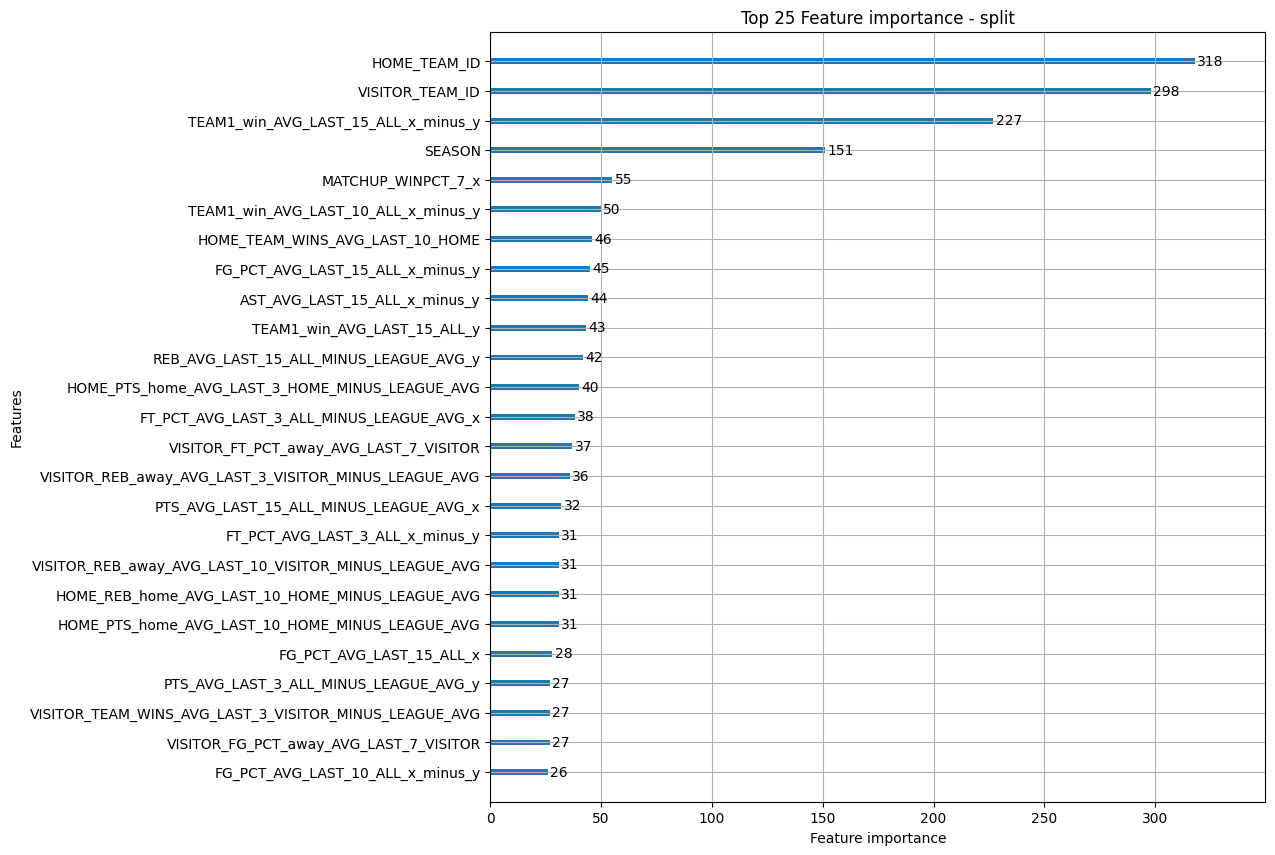

In [61]:
if MODEL_NAME == "xgboost":
    IMPORTANCE_TYPE = 'weight'
if MODEL_NAME == "lightgbm":
    IMPORTANCE_TYPE = 'split'

max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - ' + IMPORTANCE_TYPE
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type=IMPORTANCE_TYPE, max_num_features=max_features, title=max_title ,ax=ax)
#run["train/feature_importance_" + IMPORTANCE_TYPE].upload(fig)

**Train Feature Importance via Gain - the average gain of splits which use the feature**

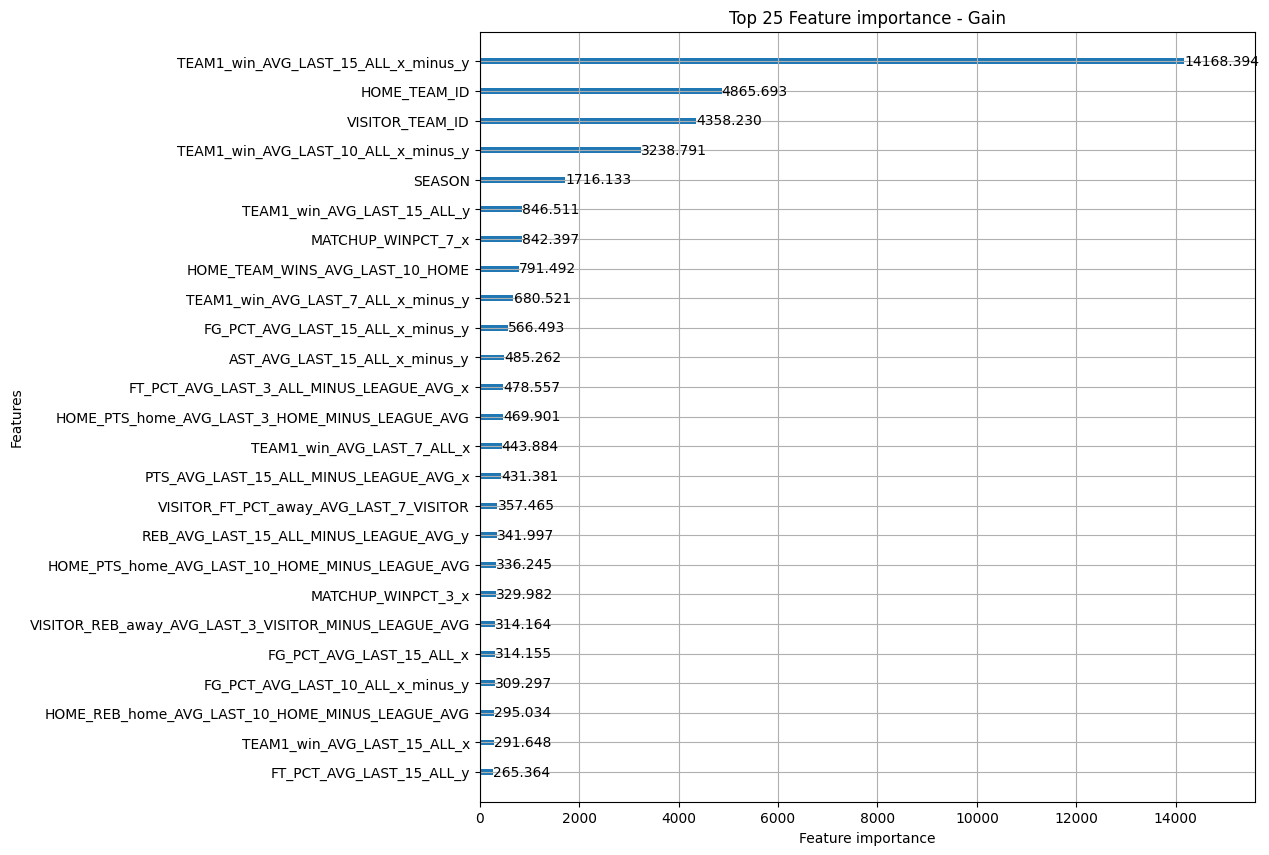

In [62]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type='gain', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_gain"].upload(fig)

**OOF Feature Importance via Shapley values**

Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 0.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 1.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 2.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 3.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 4.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 5.0
Error occurred during asynchronous opera

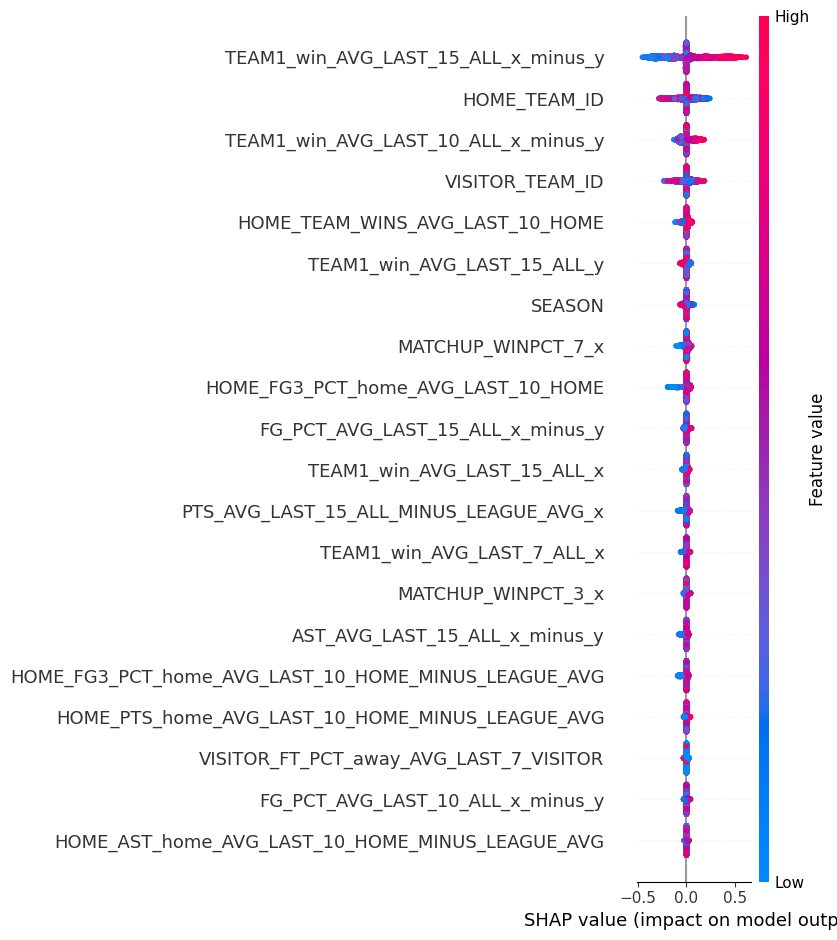

Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 55.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 56.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 57.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 58.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 59.0
Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: valid_0/auc. Invalid point: 60.0
Error occurred during asynchronous

In [63]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["train/shapley_summary"].upload(fig)

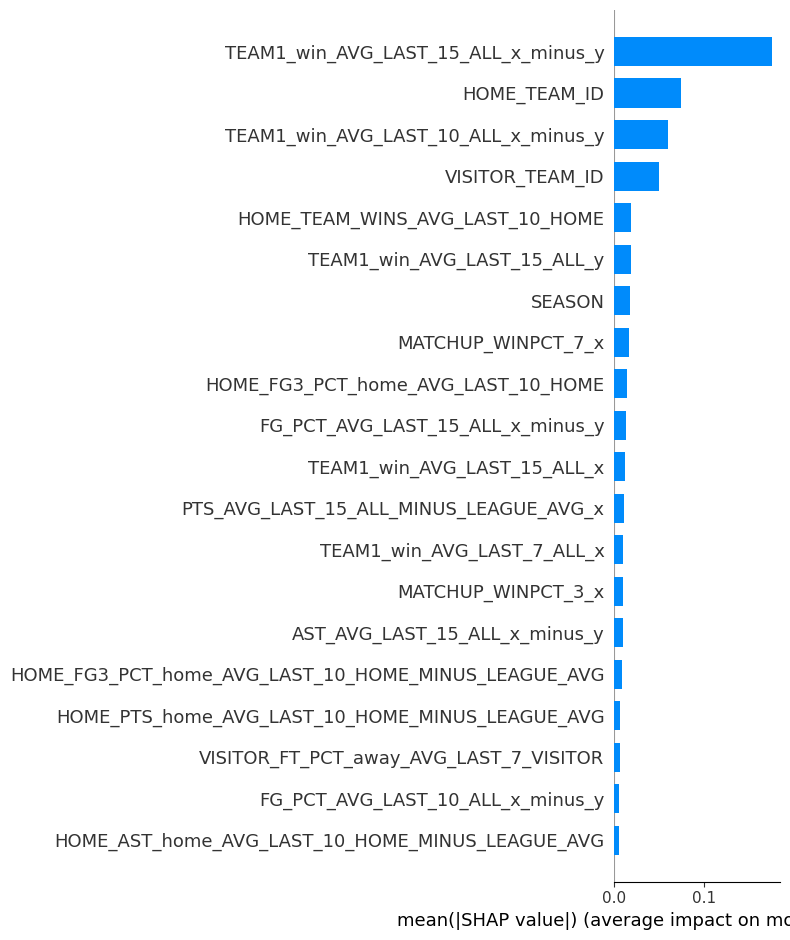

In [64]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["train/shapley_summary_bar"].upload(fig)

**Save train data with predictions**


In [65]:
train['TARGET'] = target
train['PredictionPct'] = train_oof
train['Prediction'] = train_oof_binary
train.to_csv(DATA_PATH / "processed" / "train_predictions.csv",index=False)

### Test Data Evaluation

In [66]:
if MODEL_NAME == "xgboost":
    test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
if MODEL_NAME == "lightgbm":
    test_data = test

test_preds = model.predict(test_data)
test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

run["test/accuracy"] = acc_score 
run["test/AUC"] = auc_score 
run["test/optimal_threshold"] = optimal_threshold

df = {'Label': 'Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)   




Scores:

Accuracy Score: 0.6222041480276536
AUC Score: 0.6550422127176982
Optimal Threshold: 0.5730173923066065


**Test Confusion Matrix**

In [67]:
cm = confusion_matrix(test_target, test_preds_binary)
print(cm)
fig = ConfusionMatrixDisplay(cm,display_labels=['win','lose'])
run["test/confusion_matrix"].append(fig)


[[611 466]
 [463 919]]


**Test Classification report**

In [68]:
run["test/classification_report"] = classification_report(test_target, test_preds_binary)
print(classification_report(test_target, test_preds_binary))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1077
           1       0.66      0.66      0.66      1382

    accuracy                           0.62      2459
   macro avg       0.62      0.62      0.62      2459
weighted avg       0.62      0.62      0.62      2459



**Test Feature Importance via Shapley values**

For comparison to cross-validation OOF Shapley values to ensure that the model is working in similar manner on the test data as train data

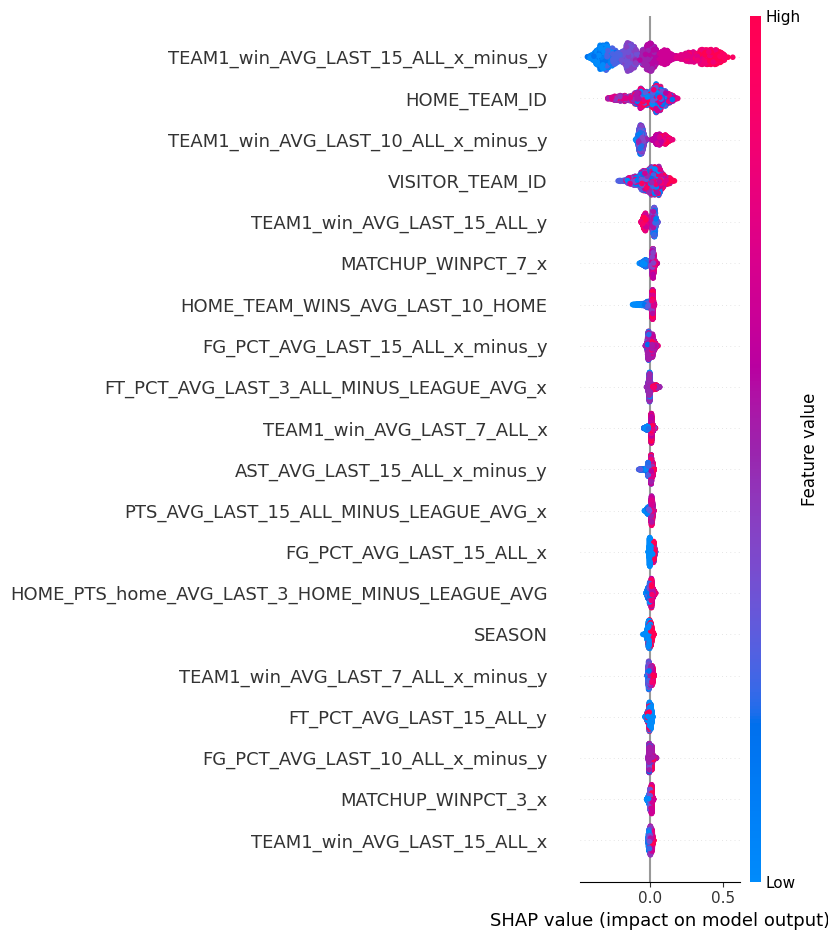

In [69]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test)
run["test/shapley_summary"].upload(fig)

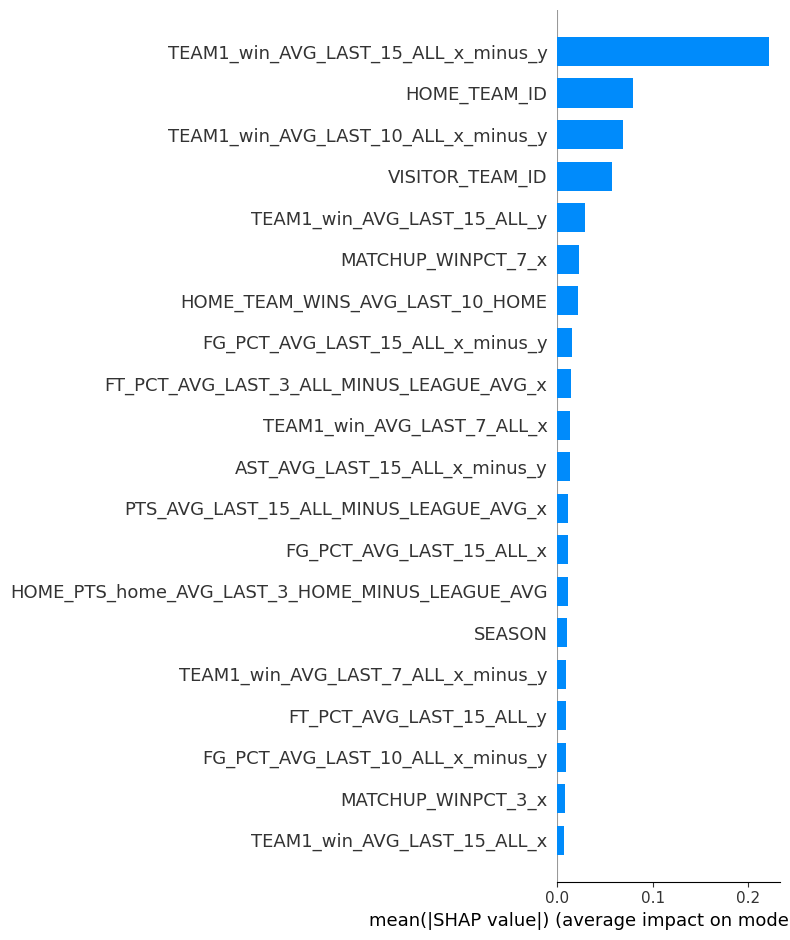

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test[use_columns], plot_type="bar")
run["test/shapley_summary_bar"].upload(fig)

**Save test data with predictions**


In [71]:
test['TARGET'] = test_target
test['PredictionPct'] = test_preds
test['Prediction'] = test_preds_binary
test.to_csv(DATA_PATH / "processed" / "test_predictions.csv",index=False)

## Model Evaluation

 - Compare Simple model predictions vs ML Test data predictions
 - Compare OOF/Train data vs Test/Validation data
 - Compare early season Test data vs later season Test data
 
 Feature importances via Shapley values are *local* to the given dataset and can assist in adversarial validation

**Split Test data**

Compare the model performance on the early part of the test data vs the later part of the test data

In [72]:
TEST_NAME

'test_selected.csv'

In [74]:
test = pd.read_csv(DATA_PATH / TEST_NAME)
test = fix_datatypes(test, DATE_FIELDS, SHORT_INTEGER_FIELDS, LONG_INTEGER_FIELDS)
test = encode_categoricals(test, CATEGORY_COLUMNS, MODEL_NAME, ENABLE_CATEGORICAL)

num_of_rows = test.shape[0] 
test = test.sort_values(by=['GAME_DATE_EST']) # sort the data by date
SPLIT = test.iloc[num_of_rows//2]['GAME_DATE_EST'] # split the data in half and find the date in the middle
 

run["test_split_Test1/end_date"] = SPLIT
run["test_split_Test2/start_date"] = SPLIT

test1 = test[test['GAME_DATE_EST'] < SPLIT]
test2 = test[test['GAME_DATE_EST'] >= SPLIT]

test1_target = test1['TARGET']
test2_target = test2['TARGET']


test1 = test1[use_columns]
test2 = test2[use_columns]

test1


,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,MONTH,HOME_TEAM_WIN_STREAK,HOME_TEAM_WINS_AVG_LAST_3_HOME,HOME_TEAM_WINS_AVG_LAST_7_HOME,HOME_TEAM_WINS_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME,HOME_PTS_home_AVG_LAST_7_HOME,HOME_PTS_home_AVG_LAST_10_HOME,HOME_FG_PCT_home_AVG_LAST_3_HOME,HOME_FG_PCT_home_AVG_LAST_7_HOME,HOME_FG_PCT_home_AVG_LAST_10_HOME,HOME_FT_PCT_home_AVG_LAST_3_HOME,HOME_FT_PCT_home_AVG_LAST_7_HOME,HOME_FT_PCT_home_AVG_LAST_10_HOME,HOME_FG3_PCT_home_AVG_LAST_3_HOME,HOME_FG3_PCT_home_AVG_LAST_7_HOME,HOME_FG3_PCT_home_AVG_LAST_10_HOME,HOME_AST_home_AVG_LAST_3_HOME,HOME_AST_home_AVG_LAST_7_HOME,HOME_AST_home_AVG_LAST_10_HOME,HOME_REB_home_AVG_LAST_3_HOME,HOME_REB_home_AVG_LAST_7_HOME,HOME_REB_home_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,VISITOR_TEAM_WIN_STREAK,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR,VISITOR_PTS_away_AVG_LAST_3_VISITOR,VISITOR_PTS_away_AVG_LAST_7_VISITOR,VISITOR_PTS_away_AVG_LAST_10_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR,VISITOR_AST_away_AVG_LAST_3_VISITOR,VISITOR_AST_away_AVG_LAST_7_VISITOR,VISITOR_AST_away_AVG_LAST_10_VISITOR,VISITOR_REB_away_AVG_LAST_3_VISITOR,VISITOR_REB_away_AVG_LAST_7_VISITOR,VISITOR_REB_away_AVG_LAST_10_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,MATCHUP_WINPCT_3_x,MATCHUP_WINPCT_7_x,MATCHUP_WINPCT_10_x,MATCHUP_WIN_STREAK_x,WIN_STREAK_x,HOME_AWAY_STREAK_x,TEAM1_win_AVG_LAST_3_ALL_x,TEAM1_win_AVG_LAST_7_ALL_x,TEAM1_win_AVG_LAST_10_ALL_x,TEAM1_win_AVG_LAST_15_ALL_x,PTS_AVG_LAST_3_ALL_x,PTS_AVG_LAST_7_ALL_x,PTS_AVG_LAST_10_ALL_x,PTS_AVG_LAST_15_ALL_x,FG_PCT_AVG_LAST_3_ALL_x,FG_PCT_AVG_LAST_7_ALL_x,FG_PCT_AVG_LAST_10_ALL_x,FG_PCT_AVG_LAST_15_ALL_x,FT_PCT

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10081 entries, 9423 to 1300
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int16(5), int32(1), int8(16)
memory usage: 4.7 MB


**Process Splits**

TEST1

Scores:

Accuracy Score: 0.6660051597539194
AUC Score: 0.7154296822866042
Optimal Threshold: 0.5759583118416621
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      2068
           1       0.73      0.69      0.71      2971

    accuracy                           0.67      5039
   macro avg       0.66      0.66      0.66      5039
weighted avg       0.67      0.67      0.67      5039



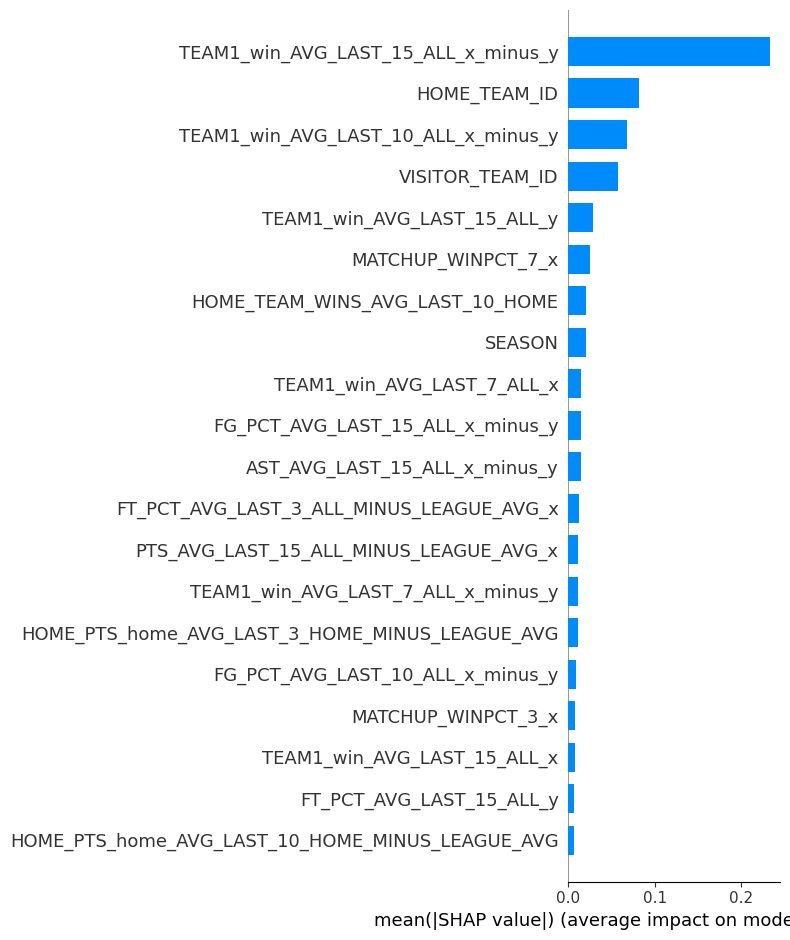

TEST2

Scores:

Accuracy Score: 0.6261404204680683
AUC Score: 0.6732539596476343
Optimal Threshold: 0.5907099843164482
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      2230
           1       0.68      0.62      0.65      2812

    accuracy                           0.63      5042
   macro avg       0.63      0.63      0.62      5042
weighted avg       0.63      0.63      0.63      5042



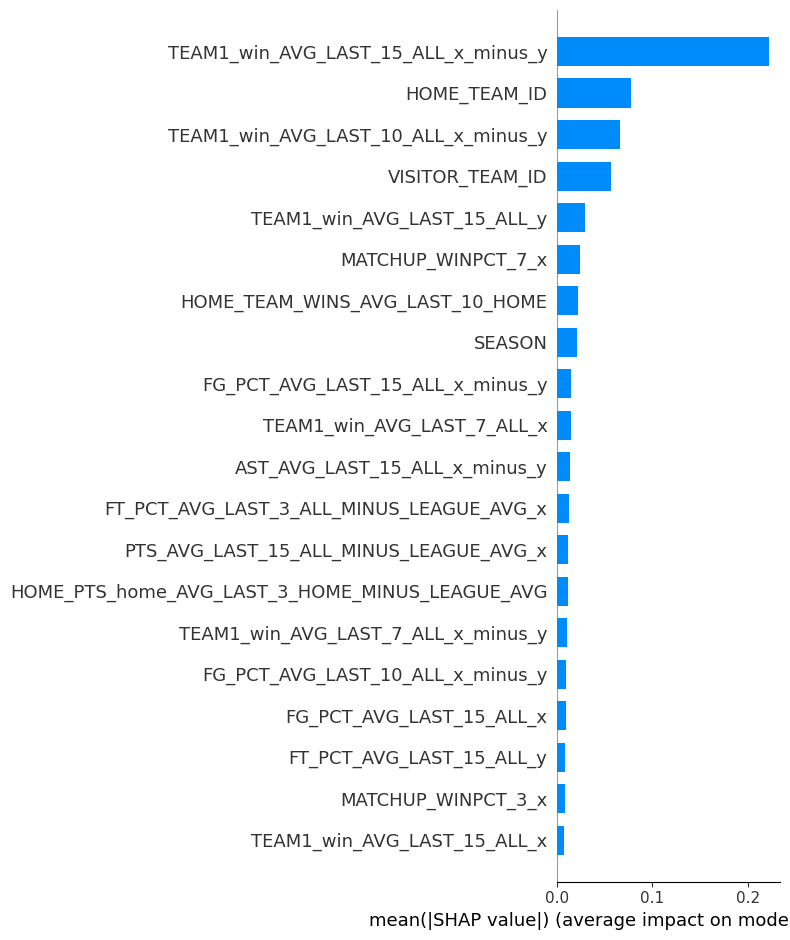

In [76]:
def process_splits(label, test, test_target, results):

    if MODEL_NAME == "xgboost":
        test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
    if MODEL_NAME == "lightgbm":
        test_data = test

    test_preds = model.predict(test_data)
    test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

    test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

    run["test_split_" + label + "/accuracy"] = acc_score 
    run["test_split_" + label + "/AUC"] = auc_score 
    run["test_split_" + label + "/optimal_threshold"] = optimal_threshold

    df = {'Label': label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
    results = results.append(df, ignore_index = True) 

    run["test_split_" + label + "/classification_report"] = classification_report(test_target, test_preds_binary)
    print(classification_report(test_target, test_preds_binary))
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    shap.summary_plot(test_preds_shap[:,:-1], test, plot_type="bar")
    #run["test_split_" + label + "/shapley_summary_bar"].upload(fig)

    #Simple model applied to split
    acc_score, auc_score = SimpleModel(test, test_target)
    df = {'Label': 'Simple-' + label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
    results = results.append(df, ignore_index = True) 
    
    return test_preds_shap, results
    
print("TEST1")
test_preds_shap1, results = process_splits('Test1',test1, test1_target, results)
print("TEST2")
test_preds_shap2, results = process_splits('Test2',test2, test2_target, results)


**Summary Table**

Key metrics from Simple Model, Train, Test, and Test-split

In [77]:
acc_score1  = results.loc[results['Label'] == 'Train', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Train', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Train-Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/train-test_accuracy"] = acc_score
run["evaluation/train-test_AUC"] = auc_score

acc_score1  = results.loc[results['Label'] == 'Test1', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test2', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Test1', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test2', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Test1-Test2', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/test1-test2_accuracy"] = acc_score
run["evaluation/test1-test2_AUC"] = auc_score

run["evaluation/summary_table"].upload(File.as_html(results))
results

,Label,Accuracy,AUC,Threshold
0,Simple Model,0.562017,0.500000,N/A
1,Train,0.591508,0.623054,0.595907
2,Test,0.622204,0.655042,0.573017
3,Test1,0.666005,0.715430,0.575958
4,Simple-Test1,0.589601,0.500000,N/A
5,Test2,0.626140,0.673254,0.59071
6,Simple-Test2,0.557715,0.500000,N/A
7,Train-Test,-0.030696,-0.031988,N/A
8,Test1-Test2,0.039865,0.042176,N/A


**Train vs Test Feature Importances via Shapley Values**

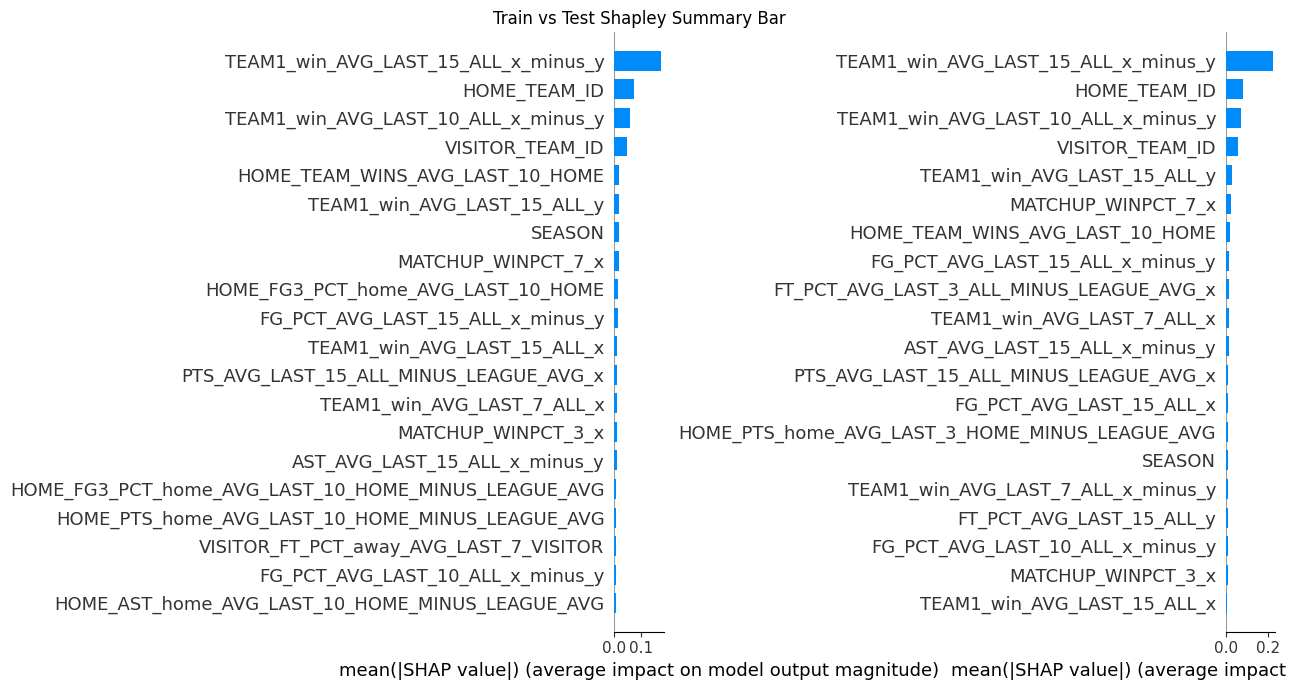

In [78]:
fig = plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.title('Train vs Test Shapley Summary Bar')
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()

fig.show()
#run["evaluation/test_train_shapley_summary_bar"].upload(fig)

**Test1 vs Test2 Feature Importances via Shapley Values**

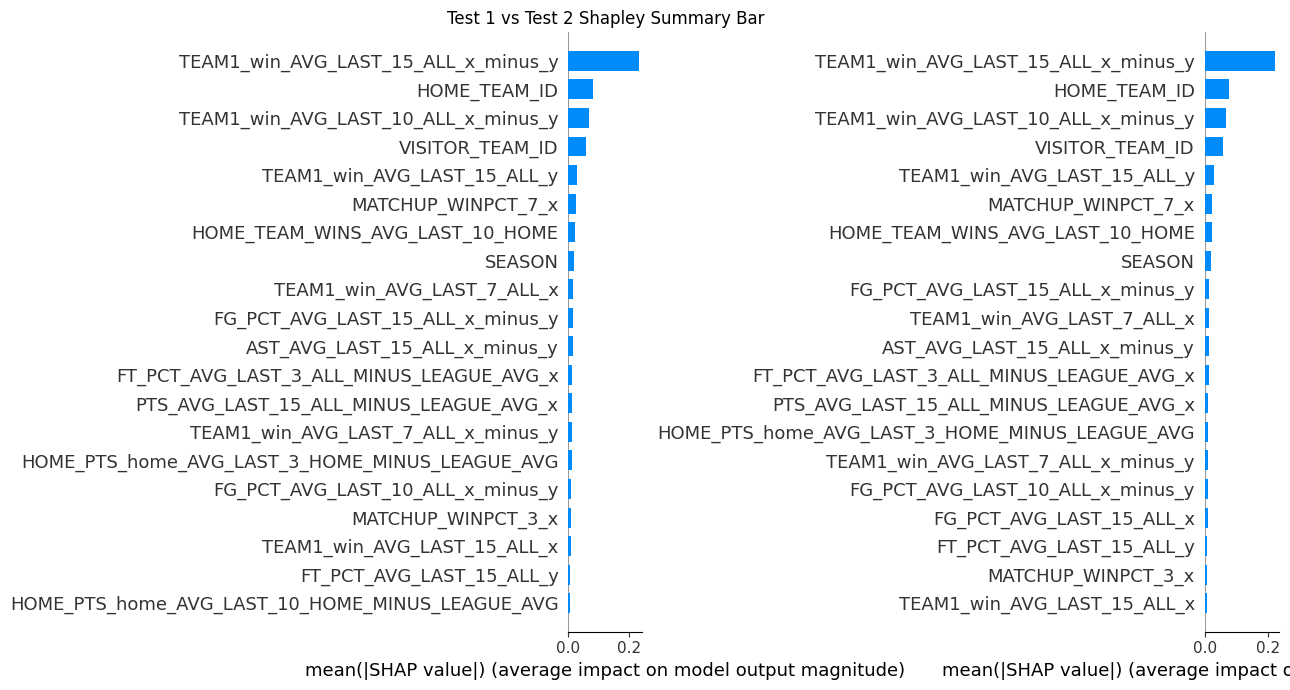

In [79]:
fig = plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.title('Test 1 vs Test 2 Shapley Summary Bar')
shap.summary_plot(test_preds_shap1[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap2[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
#run["evaluation/test1_test2_shapley_summary_bar"].upload(fig)

**End experiment tracking**

In [80]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...


Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/massyl/nba-match-prediction/e/NBAM-51/metadata


**Save Tuned Hyperparameters**

Optional function - when run, it overwrites the current "best" hyperparameters with the newly generated hyperparameters. Some descretion is required.

In [81]:
def save_tuned_params(MODEL_NAME, tuned_params):
    with open(CONFIGS_PATH / (MODEL_NAME + '.json'), 'w') as f:
        f.write(json.dumps(tuned_params))
        
save_tuned_params(MODEL_NAME, tuned_params)

**Visualize Data Comparisons**

In [83]:
# run Sweetviz comparing test data that led to a correct prediction vs incorrect prediction

test = pd.read_csv(DATA_PATH / "processed" / 'test_predictions.csv')

test['TARGET'] = test['TARGET'].astype('int8')
test['Prediction'] = test['Prediction'].astype('int8')

test_correct = test[test['TARGET'] == test['Prediction']]
test_wrong = test[test['TARGET'] != test['Prediction']]

#run_sweetviz_comparison(test_correct, 'Test-Correct', test_wrong, 'Test-Wrong', 'Prediction', 'correct-incorrect')

**Calibrate Probabilities**

The goal of the prediction model is to predict the probability of a win or loss for each game. We need to make sure that the model is predicting probabilities that are in line with the actual win/loss outcomes. The proba predictions from most classifiers do not typically align with the actual outcomes. Calibration fits a function to the model's probabilities and the actual outcomes.

The first step is to plot the actual probability distribution of the base model against a perfectly calibrated ideal distribution. In some cases, the base model may be sufficient on its own, but it can often be improved by calibrating the probabilities.

Next, we apply SKLearns built-in functions to calibrate the model's probabilities. This is done by fitting both an isotonic regression model and a sigmoid regression model to the model's probabilities and the actual outcomes. These fitted curves represent calibrated probabilities.

By plotting the graph, we can see how well the model's probabilities are calibrated. The ideal distribution is represented by the dotted line, and the model "closest" to this line is the best calibrated model.

Brier loss is typically used to numerically measure how well the model is calibrated. It is a measure of the mean squared difference between the predicted probabilities and the actual outcomes. The lower the Brier loss, the better the calibration.

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.6491171893064829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6491171893064829
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.762383104970086e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.762383104970086e-06
[LightGBM] [Warning] bagging_fraction is set=0.6777482923296312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6777482923296312
[LightGBM] [Warning] lambda_l1 is set=0.15255936704529924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15255936704529924
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.6491171893064829, colsample_bytree=1.0 will

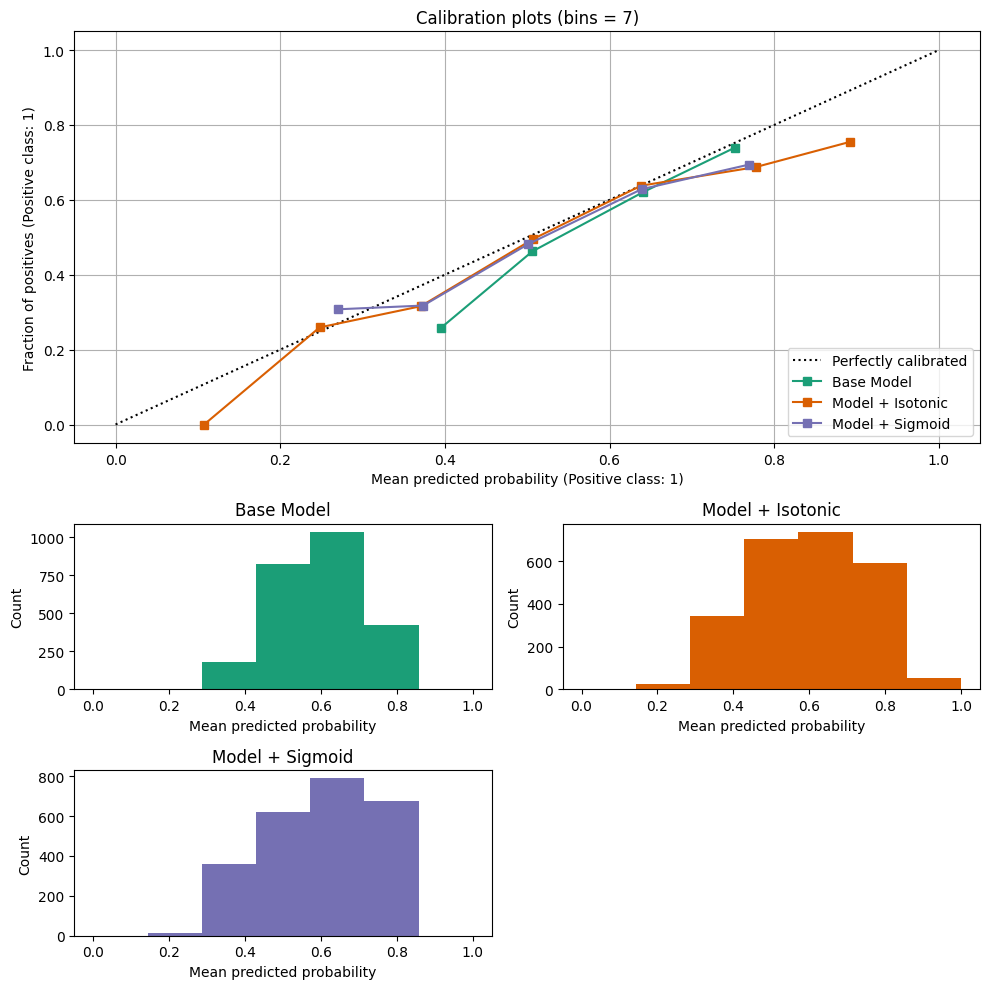

In [84]:
# since we are using SKLearn's built in functions to to calibrate and plot the probability curves, 
# we first need to convert our model to one using a SKLearn wrapper.
if MODEL_NAME == "xgboost":
    model = XGBClassifier(n_estimators=NUM_BOOST_ROUND, **model_params)
if MODEL_NAME == "lightgbm":
    model = LGBMClassifier(verbose_eval=False, **model_params)

# we then set up CalibratedClassifierCV using Isotonic and Sigmoid Regression
model_isotonic = CalibratedClassifierCV(model, cv=5, method="isotonic")
model_sigmoid = CalibratedClassifierCV(model, cv=5, method="sigmoid")

clf_list = [
    (model, "Base Model"),
    (model_isotonic, "Model + Isotonic"),
    (model_sigmoid, "Model + Sigmoid"),
]

y_train = target
y_test = test_target_original

X_train = train[use_columns]
X_test = test_original

plot_calibration_curve(clf_list, X_train, y_train, X_test, y_test, n_bins=7)

In [85]:
# calculate classification metrics we will use to compare the models
# and return an updated clf_list that includes the trained/fitted models
df_scores, clf_list = calculate_classification_metrics(clf_list, X_train, y_train, X_test, y_test)
df_scores = df_scores.reset_index()
df_scores

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.6491171893064829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6491171893064829
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.762383104970086e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.762383104970086e-06
[LightGBM] [Warning] bagging_fraction is set=0.6777482923296312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6777482923296312
[LightGBM] [Warning] lambda_l1 is set=0.15255936704529924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15255936704529924
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.6491171893064829, colsample_bytree=1.0 will

,Classifier,Brier loss,Log loss,Precision,Recall,F1,Roc auc
0,Base Model,0.229499,0.651141,0.624217,0.865412,0.725288,0.598444
1,Model + Isotonic,0.229903,0.653696,0.634066,0.835022,0.720800,0.608319
2,Model + Sigmoid,0.229382,0.651572,0.634885,0.819103,0.715324,0.607323


**Select Best Model Calibration and Save**

Select the model with the lowest Brier loss score and save the calibrated model to a pickle file. This is the model that will be used for the final predictions.

In [86]:
df_best = df_scores.loc[df_scores['Brier  loss'].idxmin()]
best_calibrated_model = df_best['Classifier']

print("Best calibrated model is: ", best_calibrated_model)


Best calibrated model is:  Model + Sigmoid


In [87]:
# save the pickeled model and key metrics so that it can be saved to the model registry later on


#retrieve the AUC and Accuracy scores for the test set from the summary table we created earlier named 'results'
test_results = results.loc[results['Label'] == 'Test'] 
# auc_score = test_results['AUC'].values[0]
# acc_score = test_results['Accuracy'].values[0]

#select the best calibrated model from the list of models we created earlier
model = [classifier for (classifier, name) in clf_list if name == best_calibrated_model][0]


joblib.dump(model, MODELS_PATH / 'model.pkl')

model_data = {
            'model_name': MODEL_NAME,
            'calibration_method': best_calibrated_model,
            'brier_loss': df_best['Brier  loss'],
            # 'metrics':{'AUC': auc_score, 'Accuracy': acc_score },
            }
    
with open(MODELS_PATH / 'model_data.json', 'w') as f:
    f.write(json.dumps(model_data))